### 채권가격 결정과 채권시장의 이해

보유자산군의 포지션이 시장이 변하면 어떻게 바뀌는지 인지하고 변화에 대처할지 결정 및 보유한 금융상품의 공정가치가 얼마인지 평가 엔진을 활용하여 가치를 측정(pricing)하는 것

#### 채권의 디폴트 위험과 채권 안정성 결정요인

* 보상 비율 = 고정자본 대비 수익/이자비용
* 레버리지 비율 = 자산 / 부채 = 충분히 수익을 내지 못할 가능성
* 유동성 비율 = 유동자산 / 유동부채 = 만기가 도래한 채권에 대한 상환능력
* 수익성 비율 = 수익 / 자산(또는 자본) = 성과
* 부채비율 = 부채 대비 현금흐름 비율 = 채무불이행

출처
* https://abhyankar-ameya.medium.com/credit-risk-analytics-with-python-survival-probabilities-via-bootstrapping-cds-spreads-3d0be1e7100c
* https://blog.naver.com/stochastic73/222172667393

In [3]:
# 데이터 처리, 선형대수와 행렬 등 연산 모듈
import numpy as np
import pandas as pd
from datetime import time, datetime, timedelta
import math
import re
import statsmodels.api as sm
import statsmodels.formula.api as sm
from statsmodels.formula.api import ols
import missingno as msno
from typing import *
import pandas_datareader as web
import pandas_datareader.data as web
import pandas_datareader as pdr

# 통계적 가설검정 모듈
from scipy.stats import *
from statsmodels.formula.api import ols

# 코랩에 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# 데이터 시각화 모듈
import seaborn as sns
import matplotlib.pyplot as plt

# 증권 데이터 웹스크래핑 모듈
# !pip install --upgrade pandas
# !pip install --upgrade pandas-datareader
# !pip install lxml
!pip install QuantLib
# !pip install pykrx
# !pip install finance-datareader
# !pip install yfinance
# !pip install pybind11
  # 의존성 모듈로 함께 설치할 것(https://riskfolio-lib.readthedocs.io/en/latest/install.html)
# !pip install riskfolio-lib

import requests
from bs4 import BeautifulSoup
import QuantLib as ql
# from pykrx import stock
# import pandas_datareader.famafrench as ff
# import FinanceDataReader as fdr
import pandas_datareader as web
from pandas_datareader.famafrench import get_available_datasets
# import yfinance as yf
# yf.pdr_override()
# import riskfolio as rp

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.9/18.9 MB 66.2 MB/s eta 0:00:00


### 위험 프리미엄 = 기간(장단기 스프레드, 7일물과 3년물 국고채 간 금리차) + 신용 프리미엄

> 국고채 3년물 금리 데이터 크롤링 > 실패

In [ ]:
request_url = "https://www.kofiabond.or.kr/proframeWeb/XMLSERVICES/"
  # 금융투자협회 채권정보센터 KOFIABOND : https://www.kofiabond.or.kr/index.html
form_data_230101_230314 = '''
                          <message>
                            <proframeHeader>
                              <pfmAppName>BIS-KOFIABOND</pfmAppName>
                              <pfmSvcName>BISBndSrtPrcSrchSO</pfmSvcName>
                              <pfmFnName>selectTrm</pfmFnName>
                            </proframeHeader>
                            <systemHeader></systemHeader>
                              <BISBndSrtPrcTrmDTO>
                              <val31>1010000</val31>
                              <val32>0300</val32>
                              <creditEstOrgCd>A20000</creditEstOrgCd>
                              <standardDt1>29990101</standardDt1>
                              <standardDt2>29990101</standardDt2>
                              <val1>A10002</val1>
                              <val2>A10003</val2>
                              <val3>A10004</val3>
                              <val4>A10005</val4>
                              <val5>A10006</val5>
                          </BISBndSrtPrcTrmDTO>
                          </message>
                          '''
  # url + html 페이로드의 양식데이터를 요청하여 받아온 채권종류 선택 리스트 반환
  # [pfmFnName] selectTrm: 만기수익률 요청
post_url = requests.post(request_url, form_data_230101_230314)
soup_object = BeautifulSoup(post_url.content, "lxml-xml")
response_tag = soup_object.find_all("proframeHeader")
  # 원하는 데이터가 있는 tag를 찾아 파싱하여 데이터프레임에 저장

In [ ]:
soup_object

<?xml version="1.0" encoding="utf-8"?>
<root><message><proframeHeader>
<pfmAppName>BIS-KOFIABOND</pfmAppName>
<pfmSvcName>BISBndSrtPrcSrchSO</pfmSvcName>
<pfmFnName>selectTrm</pfmFnName>
<pfmGlobalNo>efca64650afe009c0f9cf734086e5b15</pfmGlobalNo>
<pfmTrDate>20230317</pfmTrDate>
<pfmTrTime>20230317223744037</pfmTrTime>
<pfmClntIp>35.245.172.200</pfmClntIp>
<pfmResponseDtal/>
</proframeHeader>
<systemHeader>
</systemHeader>
<BISBndSrtPrcTrmListDTO>
<dbio_total_count_>0</dbio_total_count_>
<dbio_fetch_seq_>0</dbio_fetch_seq_>
<dbio_fetch_size_>0</dbio_fetch_size_>
<dbio_affected_count_>0</dbio_affected_count_>
</BISBndSrtPrcTrmListDTO></message></root>

In [ ]:
response_tag

[<proframeHeader>
 <pfmAppName>BIS-KOFIABOND</pfmAppName>
 <pfmSvcName>BISBndSrtPrcSrchSO</pfmSvcName>
 <pfmFnName>selectTrm</pfmFnName>
 <pfmGlobalNo>efca64650afe009c0f9cf734086e5b15</pfmGlobalNo>
 <pfmTrDate>20230317</pfmTrDate>
 <pfmTrTime>20230317223744037</pfmTrTime>
 <pfmClntIp>35.245.172.200</pfmClntIp>
 <pfmResponseDtal/>
 </proframeHeader>]

In [ ]:
column_dictionary = {
    "val1" : "bond_cd",
    "val2" : "bond_nm",
    "val3" : "bond_snm",
    "val4" : "bond_enm",
    "val5" : "gyn"
}
  # <pfmFnName> 태그 내용이 selectBndType 으로 바뀐 것

dataframe_govern_bond_return = pd.DataFrame()
for post_url in response_tag:
  dictionary = dict()
    # dictionary: Dict = {}
"""
  for index in list(column_dictionary.keys()):
    dictionary[index] = [
        post_url.find(index).text
    ]
  dataframe_sub = pd.DataFrame.from_dict(dictionary)
  dataframe_govern_bond_return = dataframe_govern_bond_return.append(dataframe_sub,
                                                                     sort = True)
"""
  # [AttributeError] 'NoneType' object has no attribute 'text'

'\n  for index in list(column_dictionary.keys()):\n    dictionary[index] = [\n        post_url.find(index).text\n    ]\n  dataframe_sub = pd.DataFrame.from_dict(dictionary)\n  dataframe_govern_bond_return = dataframe_govern_bond_return.append(dataframe_sub,\n                                                                     sort = True)\n'

> 신용부도스왑(CDS)의 가치평가(미래의 현금흐름을 추정하여 현재가치 할인)

채무불이행이나 신용스프레드 확대, 신용등급 하락 등의 신용리스크를 별도로 헤지하는 장외파생상품
* $ (1-p) \cdot e^{(z+r)t} \ (생존확률) + p \cdot Re^{(z+r)t} \ (부도확률) = e^{zt} $ 
* $ p = \frac{1 - e^{-rt}}{1 - R} $

```
z = 무위험수익률
r = 신용스프레드
z + r = 회사채 수익률 

t = 만기
p = 누적부도확률
PDt 연간부도확률
R = 회수율
```

* 신용스프레드와 회수율이 있다면 누적부도확률 p를 계산하여 시장에 내재된 내재부도확률(implied default probability)을 추정할 수 있다.
* 부도확률(default probability)이란 채권의 준거기업이 j번째 기간 중 부도를 낼 확률
* 생존확률(survival probability)이란 j번째 기간까지 특정 기간에 생존하기 위한 확률, 부도확률의 반대 개념
* 회수율(recovery rate)이란 회사의 청산가치, 액면금액 대비 얼마나 채권을 회수할 수 있는지에 대한 비율 (퀀트 대디 블로그 아티클에 따르면 일반적인 CDS 평가 모형은 회수율을 40%로 가정한다.)

CDS의 현금흐름에는 **프리미엄 레그(Leg)와 디폴트 레그**가 있다. 전자는 CDS 매도하여 얻는 프리미엄에 관한 현금흐름이며, 후자는 신용사건이 발생할 경우 보상할 현금흐름을 말한다. CDS가 공정하게 평가될 경우 프리미엄 레그의 기댓값과 디폴트 레그의 기댓값이 같아져 거래시점에 CDS 평가가격 = 0
* 신용부도스왑 프리미엄의 공정가치 $ s = \frac{(1-회수율) ⋅ Σ_{j=1}^{N} 할인계수 ⋅ 부도확률}{Σ_{j=1}^{N} 할인계수 ⋅ 생존확률 ⋅ 기간 + Σ_{j=1}^{N} 할인계수 ⋅ 부도확률 ⋅ 기간 / 2} $, s를 이용하여 역으로 시장의 내재부도확률과 내재생존확률을 추정할 수 있다.
* CDS를 평가하기 위한 **금리 커브와 CDS 커브**가 필요하다. CDS 커브는 각 tenor별로 어느 정도의 프리미엄에 신용파생상품인 신용부도스왑이 거래되고 있는지를 나타낸다. **금리 커브를 활용한 현재가치 할인으로 CDS의 이론적 가치를 평가**한다. 

* 예

  어떤 자산운용사가 15년 만기 회사채 1억 달러를 매입하였다고 가정하자. 발행 회사가 채무 불이행하지 않으면 연금 기금은 매년 이자를 지불하고 만기 시 1억 달러를 받게 된다. 

  투자자(채권자)를 보호하기 위해 금융기관과 15년 CDS 계약을 체결한다. 채권 발행 회사의 신용도에 따라 합의된 스프레드는 연간 80bp이다. 

  이는 매년 연기금 또는 보험사나 은행(CDS 매수자)이 금융기관(CDS 매도자)에게 **향후 10년 동안 매년 80,000 달러를 지불**한다는 것을 의미한다. **신용 이벤트(채무불이행)가 발생하면 CDS 매도자는 손실에 따라 CDS 매수자에게 보상**하여야 한다. 즉, 보험료를 받고 부도 시 원금을 보장하여야 한다.

* 문제는 CDS의 공정가치를 평가하려면 스왑의 가치측정방식을 알아야 하며, 스왑금리커브를 구해야 한다는 점이다. (산넘어 산)

### Trial & Error 1

In [ ]:
class Valuation_of_CreditDefaultSwap():

  def __init__(self, today_date, 
               interest_curve = None, CDS_curve = None):
    
    self.today_date = today_date
    self.interest_curve = self.getInterestQuote(today_date = self.today_rate)
    self.CDS_curve = self.getCDSQuote(today_date = self.today_rate)


  def getInterestQuote(self, path: str, excel_sheet: str, today_date: str) -> pd.DataFrame:

    # date_str = today
    # today_date = datetime.strptime(date_str, "%Y/%m/%d")

    interest_curve = pd.read_excel(path, sheet_name = excel_sheet, index_col = False)
    interest_curve["DaysToMaturity"] = np.nan
      # 새로운 변수 생성하여 빈 값 채워넣기
    interest_curve["Maturity"] = pd.to_datetime(interest_curve["Maturity"]).dt.time
      # Maturity 변수를 datetime 자료형으로 지정하기
    for tenor in interest_curve.index:
      # CDS 커브 데이터의 각 인덱스(행)을 tenor 변수로 설정하기
      interest_curve.loc[tenor, "DaysToMaturity"] = (interest_curve.loc[tenor, "Maturity"] - today_date).days
        # 현재시점부터 만기까지의 일수를 DaysToMaturity 변수에 넣기 
    self.interest_curve = interest_curve

    return self.interest_curve


  def getCDSQuote(self, path: str, excel_sheet: str, today_date: str) -> pd.DataFrame:

    # date_str = today
    # today_date = datetime.strptime(date_str, "%Y/%m/%d")

    CDS_curve = pd.read_excel(path, sheet_name = excel_sheet, index_col = False)
    CDS_curve["DaysToMaturity"] = np.nan
      # 새로운 변수 생성하여 빈 값 채워넣기
    CDS_curve["Maturity"] = pd.to_datetime(CDS_curve["Maturity"]).dt.time
      # Maturity 변수를 datetime 자료형으로 지정하기
    for tenor in CDS_curve.index:
      # CDS 커브 데이터의 각 인덱스(행)을 tenor 변수로 설정하기
      CDS_curve.loc[tenor, "DaysToMaturity"] = (CDS_curve.loc[tenor, "Maturity"] - today_date).days
        # 현재시점부터 만기까지의 일수를 DaysToMaturity 변수에 넣기 
        # [TypeError] unsupported operand type(s) for -: 'datetime.time' and 'datetime.datetime'
    self.CDS_curve = CDS_curve

    return self.CDS_curve

  
  def SWAPCurve(today, dataframe: pd.DataFrame):
    # 스왑금리 = 장외파생상품을 위한 금리 : https://github.com/lballabio/QuantLib/tree/master/ql
    # 스왑커브를 만들기 위해서는 스왑 하나만 필요한 것이 아니라 단기 쪽을 구성하고 있는 다른 상품들로부터 금리 추출이 필요함
  
  # 1. 스왑금리커브가 3부분으로 이루어져 있기에 각 상품(1. LIBOR금리 | 2. 유로달러선물 | 3. 스왑)에 대한 헬퍼 함수 준비하기
    London_interbank_offered_rate = dataframe[dataframe["InstType"] == "CASH"]
    futures = dataframe[dataframe["InstType"] == "FUTURE"]
    swap = dataframe[dataframe["InstType"] == "SWAP"]

  # 2. 평가일자 정의
    todays_date = ql.Date(today.day, today.month, today.year)
    ql.Settings.instance().evaluationDate = todays_date
  
  # 3. 시장관행에 따라 필요한 변수를 정의
    calendar = ql.UnitedStates()
      # 달력
    day_count = ql.Actual360()
      # 일수계산방식 day_count = Actual365Fixed()
    convention = ql.ModifiedFollowing
    settlement_days = 2
      # 결제일
    frequency = ql.Semiannual

    return London_interbank_offered_rate, futures, swap

"""
    swapHelper = [
        ql.SwapRateHelper(
            ql.QuoteHandle(ql.SimpleQuote(rate / 100)),
            ql.Period(int(day), ql.Days),
            calendar,
            frequency,
            convention,
            day_count,
            ql.Euribor3M()
    )
        for day, rate in 
        zip( London_interbank_offered_rate["DaysToMaturity"], 
             London_interbank_offered_rate["Market.Mid"])
    ]

    helper = London_interbank_offered_rate + 
"""
  
  if __name__ == "__main__":
    today_date = datetime(2023, 3, 17)

    interest_quote = getInterestQuote(
                                      today_date = today_date)
    CDS_quote = getCDSQuote(path = "/content/drive/MyDrive/FindAlpha_RiskyAsset1/data/IRS_CDS_Data.xlsx",
                            excel_sheet = "ROKCDS", 
                            today_date = today_date)

    print(interest_quote, "\n", CDS_quote)

  else:
    pass



  # def CDSCurve(today, CDS_quote, discount_curve):


TypeError: ignored

In [ ]:
CDS.getInterestQuote(
    path = "/content/drive/MyDrive/FindAlpha_RiskyAsset1/data/IRS_CDS_Data.xlsx",
    excel_sheet = "USDIRS", 
    today = "2023/3/17")
# excel_sheet = "ROKCDS"
# https://github.com/Ameya1983/TheAlchemist

TypeError: ignored

### Trial & Error 2

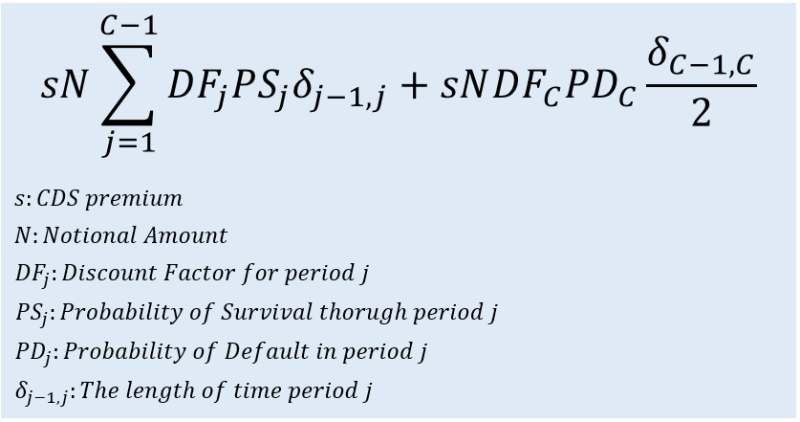

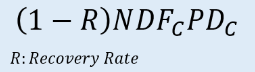

In [4]:
class CashFlow_of_CreditDefaultSwap():

  def __init__(self, number_of_premium_payments = None):
    
    self.number_of_premium_payments = number_of_premium_payments

# 프리미엄 레그 = CDS 매도하여 얻는 프리미엄에 관한 현금흐름(부도 나기 전 고정된 수수료 및 부도가 발생할 때 받을 일부 프리미엄)
# CDS 프리미엄 즉, 수수료는 basis point(0.01%) 단위로 분기별 지급
  def premium_leg(spread, 
                  number_of_premium_payments, 
                  corresponding_denominator, 
                  intervals, 
                  hazard_rates):
    
    premiums = 0
    probability_begin = 1.0

    for n in range(1, number_of_premium_payments + 1, 1):
      probability_tail = probability_begin * math.exp(-1 * hazard_rates[n - 1] * intervals[n - 1])
      premiums += 0.5 * spread * pow(corresponding_denominator[n - 1], -1 * n) * intervals[n - 1] * (probability_begin + probability_tail)
      probability_begin = probability_tail

    return premiums
  

# 디폴트 레그[프로텍션 레그] = 신용사건이 발생할 경우 보상할 현금흐름
  def protection_leg(recovery_rate,
                     number_of_premium_payments,
                     corresponding_denominator, 
                     intervals, 
                     hazard_rates):
    
    protection = 0
    probability_begin = 1.0

    for n in range(1, number_of_premium_payments + 1, 1):
      probability_tail = probability_begin * math.exp(-1 * hazard_rates[n - 1] * intervals[n - 1])
      protection += (1 - recovery_rate) * pow(corresponding_denominator[n - 1], -1 * n) * intervals[n - 1] * (probability_begin - probability_tail)
      probability_begin = probability_tail
    
    return protection

In [8]:
CF = CashFlow_of_CreditDefaultSwap() 

In [ ]:
premium = CF.premium_leg(
    spread = 0.01, 
    number_of_premium_payments = 2, 
    corresponding_denominator = [1.03, 1.03], 
    intervals = [0.5, 0.5], 
    hazard_rates = 0.02)
  # ???